<center><h1>Mapping the emotional face. How individual face parts contribute to successful emotion recognition.</h1></center>

# 3. Applying Weights  

Here, a weight factor is computed for each tile in each trial. This is the basic metric which serves as input to all the following notebooks.

In [1]:
from myBasics import *

%matplotlib inline

In [2]:
logList = getFile('../rawTables/','pand*.csv')


### The formula:

Here, each tile gets a value assigned. This works according to the following formula:
    
    
$$weight = \frac{1}{n}\sum_{i}^{n}({1-\frac{list\ lenght}{max\ length}})$$  

This means that a weight is assigned to each tile belonging to trial i.
The weigth is computed by:
- taking the lenght of the trial and dividing it by the maximum possible length;  
this gives small numbers for long trials and large numbers for short trials
- since we want to have a higher weight for short trials we do 1 minus this term
- since very long trials are non-diagnostic, we only do this for trials that contain 16 revealed tiles or less. This number was derived by taking the 75th percentile of all trial length. Using this cutoff makes our formula much more sensitive, because if we divided the list length by 48 (maximal possible number of tiles revealed), it would make less of a difference e.g. if a trial had length 4 or 8 (4/48 and 8/48 gives only a difference of 1/12) then if we scale by the more stringent cutoff (where a difference of 4 tiles translates into a weight difference of 1/4th).  

What results is a weight factor for each tile, which is conditional on the length of the trial the tile was part of. If a tile is often part of short trials, we assume that it is more diagnostic. The most extreme case would be if the tile alone can give rise to a correct answer.  

We have 16 trials per face, but since we use a cutoff for the maximal allowed trial length, there can be fewer.  
The lowest number of zero would be achieved, if a tile was never part of any trial.
The maximal number of one can actually not be achieved, because it would mean that a participant always gives a correct answer without having seen any tile revealed (1-0 for all trials). Even if that would happen, there would be no tile that could get that weight assigned.
In theory, a tile could be always the first one revealed and always sufficient by itself to trigger a correct response. Then its weight would be 1-1/16 = 15/16. This is in so far very unrealistic, as the chance to be the first one revealed is 1/48 in the first place.  

Therefore, given the amount of tiles and the low probabilities associated, very low weight numbers are to be expected.

### get distribution of trial lengths

Here, we take all trial lengths (= number of revealed tiles) form all participants, put them in one big list and then inspect its distribution to decide on a cutoff value. We come to the conclusion that a cutoff of 16 is reasonable.

In [3]:
allMasks = []
for logFile in logList:
    thisDf = pd.read_csv(logFile,header=0,index_col=[0,1,2])
    thisMasks = list( thisDf['maskNum'] )
    allMasks = allMasks+thisMasks

75% percentile: 16.0


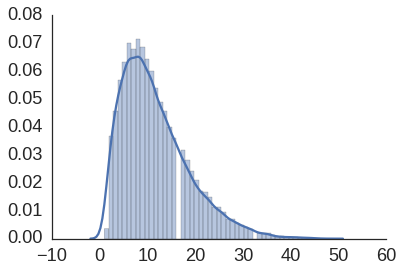

In [4]:
sns.distplot( allMasks );
sns.despine()
print '75% percentile:', np.percentile(allMasks, 75+1)

In [5]:
def getWeight(df,thisName,ident,express,n=16,identDict=identDict,emoDict=emoDict):
    
    d = {}
    
    # get the current condition (face identity and emotion expression)
    thisDf = pd.DataFrame(df.ix[ident].ix[express])

    # loop through all trials of that condition
    for i in thisDf.index:
        # we only consider correct trials, so on incorrect trials,
        # we don't do nothing
        if thisDf.ix[i]['evaluation'] != 'HIT':
            pass
            
        # if the a correct answer was given in the current trial
        else:
            # we get the list of revealed tiles
            maskList = thisDf.ix[i]['maskList']
            thisSplit = maskList.split('-')
            # if the current trial is short enough
            if len(thisSplit) <= n:
                    
                # we apply the above formula to get a weight for the importance of that trial
                    
                ####
                thisFormula = 1. - (len(thisSplit)/float(n) ) 
                ####
                    
                # now each tile of that trial gets that weight assigned, because it was
                # part of this trial
                for num in thisSplit:
                    # we try to append, if this does not work, we create the entry
                    try:
                        d[num].append(thisFormula)
                    except:
                        d[num] = [thisFormula]
                            
                # everyone else not present gets a zero
                # this works by having a list of all possible tile indices (0-47)
                # and removing indeces of all trial that were actually present
                unassigned = range(48)
                for num in thisSplit: unassigned.remove( int(num) )
                # now each tile that was not in the trial gets a zero for having been absent
                for num in unassigned:
                    try:
                        d[str(num)].append(0)
                    except:
                        d[str(num)] = [0]
    
    # note that if a trial contained an incorrect answer or was not short enough, it is
    # entierly ignored. This might not be desireable, however. E.g. one might argue that
    # if a tile is often part of an incorrect trial, it should get a negative weight
    # so there are certainly many possibilities to make the formula more sophisticated
    
    #average over all trials for each tile 
    outDf = pd.DataFrame( pd.DataFrame( d ).mean() )
    # make the index nice and restructure
    outDf.index = [int(x) for x in outDf.index]
    outDf = outDf.sort_index()
    outDf = outDf.T
    outDf.index = [[thisName],[identDict[ident]],[emoDict[express]]]
    outDf = outDf.sortlevel()
    # return a row with all values of the current expression
    return outDf

Example with one face of one participant:

In [6]:
df = pd.read_csv(logList[-1],
                 header=0,
                 index_col=[0,1,2]
                )

In [7]:
getWeight(df,'test',0,0)

,,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
test,f,hap,0,0,0.052083,0.25,0.041667,0,0,0.015625,0.0625,0,0.015625,0.052083,0.0625,0.171875,0,0.057292,0.0625,0.098958,0.015625,0.052083,0.114583,0.067708,0.067708,0.057292,0.015625,0,0.041667,0.052083,0.067708,0.265625,0.015625,0.052083,0,0.010417,0.130208,0.0625,0.119792,0.166667,0.057292,0.161458,0.010417,0.046875,0,0.078125,0.130208,0.119792,0.046875,0.09375


### get all faces of one participant

In [8]:
def getParticipantWeights(logfile):
    
    # read the contents of the logfile into a dataframe
    df = pd.read_csv(logfile,
                     header=0,
                     index_col=[0,1,2])
    
    # get the naming of the current participant right
    thisName = 'p'+logfile[logfile.rfind('e')+1:logfile.rfind('.')]
    
    # make a df with all faces for that participant
    bigWeight = pd.DataFrame()
    for ident in range(2):
        for emo in  range(7):
            thisWeight = getWeight(df,thisName,ident,emo)
            bigWeight = pd.concat([bigWeight,thisWeight])
    bigWeight = bigWeight.sortlevel()
    return bigWeight

Example:

In [9]:
getParticipantWeights(logList[-1])

0         1         2         3         4         5   \
p096 f ang  0.000000  0.150000  0.087500  0.056250  0.056250  0.137500   
       dis  0.051136  0.045455  0.045455  0.204545  0.130682  0.142045   
       fea  0.078125  0.000000  0.000000  0.031250  0.078125  0.000000   
       hap  0.000000  0.000000  0.052083  0.250000  0.041667  0.000000   
       ntr  0.085938  0.054688  0.054688  0.054688  0.031250  0.093750   
       sad  0.062500  0.125000  0.171875  0.000000  0.000000  0.000000   
       sup  0.039773  0.119318  0.096591  0.062500  0.056818  0.000000   
     m ang  0.104167  0.000000  0.000000  0.000000  0.052083  0.000000   
       dis  0.000000  0.156250  0.132812  0.054688  0.148438  0.156250   
       fea  0.000000  0.093750  0.093750  0.177083  0.083333  0.177083   
       hap  0.062500  0.066964  0.075893  0.093750  0.035714  0.026786   
       ntr  0.312500  0.000000  0.000000  0.000000  0.000000  0.000000   
       sad  0.000000  0.062500  0.125000  0.000000  0.000000  0.046875   
       sup  0.022727  0.085227  0.062500  0.022727  0.000000  0.000000   

                  6         7         8         9         10        11  \
p096 f ang  0.093750  0.056250  0.087500  0.050000  0.000000  0.000000   
       dis  0.000000  0.107955  0.039773  0.056818  0.068182  0.096591   
       fea  0.000000  0.078125  0.046875  0.031250  0.000000  0.046875   
       hap  0.000000  0.015625  0.062500  0.000000  0.015625  0.052083   
       ntr  0.054688  0.171875  0.109375  0.046875  0.164062  0.000000   
       sad  0.000000  0.000000  0.000000  0.000000  0.109375  0.125000   
       sup  0.250000  0.000000  0.096591  0.000000  0.079545  0.028409   
     m ang  0.000000  0.000000  0.125000  0.000000  0.104167  0.000000   
       dis  0.148438  0.078125  0.000000  0.226562  0.125000  0.078125   
       fea  0.114583  0.072917  0.000000  0.000000  0.187500  0.083333   
       hap  0.026786  0.026786  0.000000  0.053571  0.129464  0.071429   
       ntr  0.000000  0.281250  0.000000  0.312500  0.281250  0.000000   
       sad  0.078125  0.046875  0.250000  0.125000  0.000000  0.140625   
       sup  0.000000  0.096591  0.068182  0.107955  0.000000  0.056818   

                  12        13        14        15        16        17  \
p096 f ang  0.106250  0.137500  0.043750  0.093750  0.168750  0.093750   
       dis  0.022727  0.045455  0.005682  0.079545  0.062500  0.085227   
       fea  0.000000  0.031250  0.000000  0.046875  0.062500  0.000000   
       hap  0.062500  0.171875  0.000000  0.057292  0.062500  0.098958   
       ntr  0.062500  0.062500  0.078125  0.000000  0.070312  0.031250   
       sad  0.062500  0.062500  0.000000  0.109375  0.000000  0.234375   
       sup  0.000000  0.102273  0.028409  0.079545  0.000000  0.028409   
     m ang  0.072917  0.125000  0.052083  0.000000  0.000000  0.104167   
       dis  0.015625  0.000000  0.148438  0.093750  0.140625  0.054688   
       fea  0.104167  0.145833  0.208333  0.000000  0.072917  0.000000   
       hap  0.098214  0.022321  0.000000  0.102679  0.000000  0.062500   
       ntr  0.281250  0.593750  0.000000  0.000000  0.000000  0.000000   
       sad  0.062500  0.000000  0.000000  0.000000  0.078125  0.187500   
       sup  0.159091  0.000000  0.306818  0.090909  0.119318  0.022727   

                  18        19        20        21        22        23  \
p096 f ang  0.131250  0.000000  0.050000  0.075000  0.056250  0.175000   
       dis  0.068182  0.068182  0.062500  0.102273  0.113636  0.000000   
       fea  0.031250  0.062500  0.046875  0.000000  0.000000  0.031250   
       hap  0.015625  0.052083  0.114583  0.067708  0.067708  0.057292   
       ntr  0.039062  0.078125  0.125000  0.187500  0.062500  0.054688   
       sad  0.000000  0.187500  0.062500  0.000000  0.000000  0.109375   
       sup  0.039773  0.113636  0.085227  0.119318  0.085227  0.079545   
     m ang  0.125000  0.000000  0.000000  0.312500  0.052083  0.104167   
       dis  0.17968

### do a transformation to percent signal change  

like in [fMRI](http://mindhive.mit.edu/node/86), we use a formula like so:  

$$psc = \frac{value}{mean}*100-100$$ 

In [10]:
def makePSC(logfile):
    
    # get the raw weights
    bigWeight = getParticipantWeights(logfile)
    
    # normalize
    byMean = bigWeight.T/bigWeight.T.mean()
    scaledDf = (( ( byMean ).T )*100) -100 # that's the PSC formula
    
    return scaledDf

Example:

In [11]:
getParticipantWeights(logList[-1]).head()


0         1         2         3         4         5   \
p096 f ang  0.000000  0.150000  0.087500  0.056250  0.056250  0.137500   
       dis  0.051136  0.045455  0.045455  0.204545  0.130682  0.142045   
       fea  0.078125  0.000000  0.000000  0.031250  0.078125  0.000000   
       hap  0.000000  0.000000  0.052083  0.250000  0.041667  0.000000   
       ntr  0.085938  0.054688  0.054688  0.054688  0.031250  0.093750   

                  6         7         8         9         10        11  \
p096 f ang  0.093750  0.056250  0.087500  0.050000  0.000000  0.000000   
       dis  0.000000  0.107955  0.039773  0.056818  0.068182  0.096591   
       fea  0.000000  0.078125  0.046875  0.031250  0.000000  0.046875   
       hap  0.000000  0.015625  0.062500  0.000000  0.015625  0.052083   
       ntr  0.054688  0.171875  0.109375  0.046875  0.164062  0.000000   

                  12        13        14        15        16        17  \
p096 f ang  0.106250  0.137500  0.043750  0.093750  0.168750  0.093750   
       dis  0.022727  0.045455  0.005682  0.079545  0.062500  0.085227   
       fea  0.000000  0.031250  0.000000  0.046875  0.062500  0.000000   
       hap  0.062500  0.171875  0.000000  0.057292  0.062500  0.098958   
       ntr  0.062500  0.062500  0.078125  0.000000  0.070312  0.031250   

                  18        19        20        21        22        23  \
p096 f ang  0.131250  0.000000  0.050000  0.075000  0.056250  0.175000   
       dis  0.068182  0.068182  0.062500  0.102273  0.113636  0.000000   
       fea  0.031250  0.062500  0.046875  0.000000  0.000000  0.031250   
       hap  0.015625  0.052083  0.114583  0.067708  0.067708  0.057292   
       ntr  0.039062  0.078125  0.125000  0.187500  0.062500  0.054688   

                  24        25        26        27        28        29  \
p096 f ang  0.000000  0.056250  0.000000  0.087500  0.150000  0.081250   
       dis  0.136364  0.062500  0.045455  0.034091  0.005682  0.130682   
       fea  0.031250  0.031250  0.031250  0.000000  0.031250  0.000000   
       hap  0.015625  0.000000  0.041667  0.052083  0.067708  0.265625   
       ntr  0.070312  0.070312  0.031250  0.187500  0.187500  0.039062   

                  30        31        32        33        34        35  \
p096 f ang  0.062500  0.081250  0.050000  0.037500  0.050000  0.093750   
       dis  0.107955  0.119318  0.073864  0.034091  0.073864  0.051136   
       fea  0.000000  0.078125  0.109375  0.031250  0.109375  0.031250   
       hap  0.015625  0.052083  0.000000  0.010417  0.130208  0.062500   
       ntr  0.000000  0.070312  0.109375  0.039062  0.070312  0.000000   

                  36        37        38        39        40        41  \
p096 f ang  0.156250  0.131250  0.043750  0.106250  0.000000  0.106250   
       dis  0.113636  0.142045  0.170455  0.022727  0.000000  0.034091   
       fea  0.031250  0.000000  0.000000  0.000000  0.046875  0.000000   
       hap  0.119792  0.166667  0.057292  0.161458  0.010417  0.046875   
       ntr  0.062500  0.000000  0.000000  0.031250  0.000000  0.085938   

                  42        43        44        45        46        47  
p096 f ang  0.143750  0.000000  0.081250  0.137500  0.106250  0.000000  
       dis  0.005682  0.000000  0.068182  0.147727  0.022727  0.039773  
       fea  0.078125  0.031250  0.078125  0.000000  0.031250  0.000000  
       hap  0.000000  0.078125  0.130208  0.119792  0.046875  0.093750  
       ntr  0.117188  0.210938  0.085938  0.031250  0.109375  0.054688

In [12]:
makePSC(logList[-1]).head()

0           1           2           3           4   \
p096 f ang -100.000000   96.252129   14.480409  -26.405451  -26.405451   
       dis  -26.655348  -34.804754  -34.804754  193.378608   87.436333   
       fea  152.631579 -100.000000 -100.000000    1.052632  152.631579   
       hap -100.000000 -100.000000  -18.367347  291.836735  -34.693878   
       ntr   20.000000  -23.636364  -23.636364  -23.636364  -56.363636   

                    5           6           7          8           9   \
p096 f ang   79.897785   22.657581  -26.405451  14.480409  -34.582624   
       dis  103.735144 -100.000000   54.838710 -42.954160  -18.505942   
       fea -100.000000 -100.000000  152.631579  51.578947    1.052632   
       hap -100.000000 -100.000000  -75.510204  -2.040816 -100.000000   
       ntr   30.909091  -23.636364  140.000000  52.727273  -34.545455   

                    10          11          12          13          14  \
p096 f ang -100.000000 -100.000000   39.011925   79.897785  -42.759796   
       dis   -2.207131   38.539898  -67.402377  -34.804754  -91.850594   
       fea -100.000000   51.578947 -100.000000    1.052632 -100.000000   
       hap  -75.510204  -18.367347   -2.040816  169.387755 -100.000000   
       ntr  129.090909 -100.000000  -12.727273  -12.727273    9.090909   

                    15          16          17         18          19  \
p096 f ang   22.657581  120.783646   22.657581  71.720613 -100.000000   
       dis   14.091681  -10.356537   22.241087  -2.207131   -2.207131   
       fea   51.578947  102.105263 -100.000000   1.052632  102.105263   
       hap  -10.204082   -2.040816   55.102041 -75.510204  -18.367347   
       ntr -100.000000   -1.818182  -56.363636 -45.454545    9.090909   

                   20          21          22          23          24  \
p096 f ang -34.582624   -1.873935  -26.405451  128.960818 -100.000000   
       dis -10.356537   46.689304   62.988115 -100.000000   95.585739   
       fea  51.578947 -100.000000 -100.000000    1.052632    1.052632   
       hap  79.591837    6.122449    6.122449  -10.204082  -75.510204   
       ntr  74.545455  161.818182  -12.727273  -23.636364   -1.818182   

                    25          26          27          28          29  \
p096 f ang  -26.405451 -100.000000   14.480409   96.252129    6.303237   
       dis  -10.356537  -34.804754  -51.103565  -91.850594   87.436333   
       fea    1.052632    1.052632 -100.000000    1.052632 -100.000000   
       hap -100.000000  -34.693878  -18.367347    6.122449  316.326531   
       ntr   -1.818182  -56.363636  161.818182  161.818182  -45.454545   

                    30          31          32         33          34  \
p096 f ang  -18.228279    6.303237  -34.582624 -50.936968  -34.582624   
       dis   54.838710   71.137521    5.942275 -51.103565    5.942275   
       fea -100.000000  152.631579  253.684211   1.052632  253.684211   
       hap  -75.510204  -18.367347 -100.000000 -83.673469  104.081633   
       ntr -100.000000   -1.818182   52.727273 -45.454545   -1.818182   

                    35          36          37          38          39  \
p096 f ang   22.657581  104.429302   71.720613  -42.759796   39.011925   
       dis  -26.655348   62.988115  103.735144  144.482173  -67.402377   
       fea    1.052632    1.052632 -100.000000 -100.000000 -100.000000   
       hap   -2.040816   87.755102  161.224490  -10.204082  153.061224   
       ntr -100.000000  -12.727273 -100.000000 -100.000000  -56.363636   

                    40          41          42          43          44  \
p096 f ang -100.000000   39.011925   88.074957 -100.000000    6.303237   
       dis -100.000000  -51.103565  -91.850594 -100.000000   -2.207131   
       fea   51.578947 -100.000000  152.631579    1.052632  152.631579   
       hap  -83.673469  -26.530612 -100.000000   22.448980  104.081633   
       ntr -100.000000   20.000000   63.636364  194.545455   20.000000   

                    45         46      

### Do this for the whole sample

In [13]:
def getAllWeights(logList,func=makePSC):
    bigBig = pd.DataFrame()
    for logFile in logList:
        thisDf = func(logFile)
        bigBig = pd.concat([bigBig,thisDf],axis=0)
    bigBig = bigBig.sortlevel()
    return bigBig

In [14]:
bigWeightDf = getAllWeights(logList)

In [15]:
bigWeightDf.head()

0           1           2           3           4   \
p001 f ang -75.129534   -0.518135  132.124352 -100.000000 -100.000000   
       dis -22.330097   94.174757   -6.796117 -100.000000 -100.000000   
       fea  55.956679 -100.000000 -100.000000 -100.000000   38.628159   
       hap  25.925926   77.777778  -11.111111  -62.962963  -25.925926   
       ntr -82.385321  -82.385321   14.495413   67.339450   32.110092   

                    5           6           7           8           9   \
p001 f ang  -25.388601  -75.129534   32.642487 -100.000000  -75.129534   
       dis   39.805825  140.776699   78.640777  -22.330097 -100.000000   
       fea -100.000000   38.628159  177.256318   38.628159   55.956679   
       hap -100.000000  107.407407  -33.333333 -100.000000  107.407407   
       ntr -100.000000 -100.000000  -73.577982 -100.000000  -29.541284   

                    10          11          12         13          14  \
p001 f ang   82.383420  115.544041 -100.000000   7.772021   74.093264   
       dis  101.941748 -100.000000   78.640777  70.873786   55.339806   
       fea  177.256318   55.956679   21.299639  55.956679  159.927798   
       hap   55.555556  -25.925926   40.740741 -40.740741  -62.962963   
       ntr  111.376147  -29.541284   14.495413  67.339450   14.495413   

                    15         16          17          18          19  \
p001 f ang -100.000000 -75.129534   32.642487 -100.000000   32.642487   
       dis -100.000000  55.339806  -53.398058   -6.796117 -100.000000   
       fea   55.956679  55.956679 -100.000000   21.299639   55.956679   
       hap  -48.148148  -3.703704   11.111111 -100.000000  -70.370370   
       ntr   14.495413 -82.385321  -55.963303   67.339450 -100.000000   

                    20          21          22          23          24  \
p001 f ang   82.383420 -100.000000   -0.518135  -25.388601  -25.388601   
       dis -100.000000  164.077670  171.844660   39.805825  -61.165049   
       fea -100.000000  107.942238   21.299639 -100.000000 -100.000000   
       hap   18.518519   77.777778  -70.370370  -70.370370  -33.333333   
       ntr -100.000000  -47.155963    5.688073  -29.541284   40.917431   

                    25          26          27          28          29  \
p001 f ang  -66.839378  190.155440   32.642487  107.253886   32.642487   
       dis   32.038835    8.737864 -100.000000   -6.796117 -100.000000   
       fea -100.000000   21.299639   38.628159   21.299639  194.584838   
       hap   18.518519  -55.555556  -25.925926    3.703704   18.518519   
       ntr   -3.119266   14.495413 -100.000000  -64.770642   40.917431   

                    30          31          32          33          34  \
p001 f ang  115.544041   -0.518135 -100.000000 -100.000000 -100.000000   
       dis  296.116505  -53.398058   47.572816   -6.796117  117.475728   
       fea -100.000000 -100.000000 -100.000000   38.628159  177.256318   
       hap  -55.555556  -92.592593   85.185185   11.111111   40.740741   
       ntr   32.110092  190.642202   49.724771  181.834862   76.146789   

                    35          36          37          38          39  \
p001 f ang   32.642487   82.383420    7.772021  -25.388601  -25.388601   
       dis   32.038835 -100.000000 -100.000000  133.009709   -6.796117   
       fea   55.956679 -100.000000 -100.000000 -100.000000 -100.000000   
       hap  129.629630 -100.000000  129.629630  -25.925926   85.185185   
       ntr -100.000000  -64.770642  -29.541284   76.146789 -100.000000   

                    40          41          42          43          44  \
p001 f ang    7.772021    7.772021    7.772021  107.253886 -100.000000   
       dis -100.000000  -53.398058   -6.796117   -6.796117  -53.398058   
       fea -100.000000  194.584838 -100.000000 -100.000000   21.299639   
       hap  -25.925926  151.851852  -40.740741 -100.000000  137.037037   
       ntr   14.495413 -100.000000  340.366972    5.688073  -38.348624   

                    45          

In [16]:
bigWeightDf.to_csv('../outputs/weightDf.csv')

### do a standardization with mean zero, standard deviation 1

This is better for the PCA analyses we do later

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def makeStandard(logfile):
    
    # get the raw weights
    weightDf = getParticipantWeights(logfile)
    
    # initialise the scaler
    scaler = StandardScaler()
    # transfrom to numpy array, transpose because we want to
    # scale by observation and not by feature
    weightArray = np.array(weightDf.fillna(0)).T
    # scale
    scaledArray = scaler.fit( weightArray ).transform(  weightArray )
    # transform back to pandas, get the original structure back (transposing and using the old index of weight df)
    scaledDf = pd.DataFrame(scaledArray.T,index=weightDf.index)
    
    return scaledDf

In [19]:
bigWeightStandardDf = getAllWeights(logList,func=makeStandard)

In [20]:
bigWeightStandardDf.head()

0         1         2         3         4         5   \
p001 f ang -0.948401 -0.006541  1.667878 -1.262355 -1.262355 -0.320494   
       dis -0.245679  1.036125 -0.074772 -1.100216 -1.100216  0.437950   
       fea  0.582234 -1.040508 -1.040508 -1.040508  0.401929 -1.040508   
       hap  0.352580  1.057741 -0.151106 -0.856267 -0.352580 -1.359953   
       ntr -0.897600 -0.897600  0.157930  0.733673  0.349844 -1.089514   

                  6         7         8         9         10        11  \
p001 f ang -0.948401  0.412064 -1.262355 -0.948401  1.039971  1.458576   
       dis  1.548847  0.865218 -0.245679 -1.100216  1.121579 -1.100216   
       fea  0.401929  1.844366  0.401929  0.582234  1.844366  0.582234   
       hap  1.460690 -0.453318 -1.359953  1.460690  0.755529 -0.352580   
       ntr -1.089514 -0.801643 -1.089514 -0.321856  1.213459 -0.321856   

                  12        13        14        15        16        17  \
p001 f ang -1.262355  0.098110  0.935320 -1.262355 -0.948401  0.412064   
       dis  0.865218  0.779764  0.608857 -1.100216  0.608857 -0.587494   
       fea  0.221624  0.582234  1.664062  0.582234  0.582234 -1.040508   
       hap  0.554055 -0.554055 -0.856267 -0.654792 -0.050369  0.151106   
       ntr  0.157930  0.733673  0.157930  0.157930 -0.897600 -0.609728   

                  18        19        20        21        22        23  \
p001 f ang -1.262355  0.412064  1.039971 -1.262355 -0.006541 -0.320494   
       dis -0.074772 -1.100216 -1.100216  1.805208  1.890662  0.437950   
       fea  0.221624  0.582234 -1.040508  1.123148  0.221624 -1.040508   
       hap -1.359953 -0.957004  0.251843  1.057741 -0.957004 -0.957004   
       ntr  0.733673 -1.089514 -1.089514 -0.513771  0.061972 -0.321856   

                  24        25        26        27        28        29  \
p001 f ang -0.320494 -0.843750  2.400437  0.412064  1.353925  0.412064   
       dis -0.672947  0.352496  0.096135 -1.100216 -0.074772 -1.100216   
       fea -1.040508 -1.040508  0.221624  0.401929  0.221624  2.024671   
       hap -0.453318  0.251843 -0.755529 -0.352580  0.050369  0.251843   
       ntr  0.445801 -0.033985  0.157930 -1.089514 -0.705685  0.445801   

                  30        31        32        33        34        35  \
p001 f ang  1.458576 -0.006541 -1.262355 -1.262355 -1.262355  0.412064   
       dis  3.257920 -0.587494  0.523404 -0.074772  1.292486  0.352496   
       fea -1.040508 -1.040508 -1.040508  0.401929  1.844366  0.582234   
       hap -0.755529 -1.259216  1.158478  0.151106  0.554055  1.762902   
       ntr  0.349844  2.077074  0.541758  1.981117  0.829630 -1.089514   

                  36        37        38        39        40        41  \
p001 f ang  1.039971  0.098110 -0.320494 -0.320494  0.098110  0.098110   
       dis -1.100216 -1.100216  1.463394 -0.074772 -1.100216 -0.587494   
       fea -1.040508 -1.040508 -1.040508 -1.040508 -1.040508  2.024671   
       hap -1.359953  1.762902 -0.352580  1.158478 -0.352580  2.065113   
       ntr -0.705685 -0.321856  0.829630 -1.089514  0.157930 -1.089514   

                  42        43        44        45        46        47  
p001 f ang  0.098110  1.353925 -1.262355  1.039971  1.353925  1.039971  
       dis -0.074772 -0.074772 -0.587494 -0.587494 -1.100216 -0.416586  
       fea -1.040508 -1.040508  0.221624 -1.040508  0.221624  0.221624  
       hap -0.554055 -1.359953  1.863639 -1.359953  0.251843  1.762902  
       ntr  3.708346  0.061972 -0.417814 -0.705685  1.981117  0.253887

In [21]:
bigWeightStandardDf.to_csv('../outputs/weightStdDf.csv')

### Do an average with the PSC weights

In [22]:
def getAverageWeight(bigWeightDf):
    bigWeightAvgDf = bigWeightDf.groupby(level=[1,2]).mean()
    return bigWeightAvgDf

In [23]:
bigAvgWeightDf = getAverageWeight(bigWeightDf)

In [24]:
bigAvgWeightDf 

0          1          2          3          4          5   \
f ang  -7.354947  -7.805702   3.006315 -13.034124 -18.757770   8.792441   
  dis -18.041983   3.937812 -22.837764 -15.128121 -13.700682 -22.043449   
  fea  10.195612 -10.988335 -15.378811  -4.282311  -2.614065 -35.234560   
  hap  -5.777886 -12.469828  -5.674466  -0.271513 -13.049266  -9.012192   
  ntr  -8.954666  -4.624652  12.442949  -6.284468  -1.687176  -2.295681   
  sad  31.736929 -18.446084  -0.598245 -22.573608  -9.589268  -5.164410   
  sup -19.162343   2.434593 -19.036665 -15.455387   7.602216 -21.741832   
m ang -17.663058  -7.649570   2.524516 -10.906288  -2.929056 -13.779441   
  dis -18.482278   0.282525  -5.944005   0.979984 -19.151919  -5.696637   
  fea -10.099872 -25.409541  -5.964443 -14.840034  -3.721446 -14.381879   
  hap  -4.659852 -20.685601  -4.239779  -7.556644 -13.644443  -8.153146   
  ntr -16.366721 -10.237236  -5.728343 -16.153067  -4.213632  10.906716   
  sad -13.938410 -11.938944 -17.795451 -37.381813  -9.654425 -12.775000   
  sup  -6.663781 -11.952487   3.328154  -2.854515  -3.976193 -22.930099   

              6          7          8          9           10         11  \
f ang -11.307107 -11.584066 -17.873372  -7.605425   38.741684   0.621276   
  dis -12.648803  -1.704436 -13.620330 -18.142441   -9.516321   4.598998   
  fea -17.069579   6.199092  -3.946539   8.085170   86.206851 -19.193472   
  hap -13.553572 -13.973723  -9.404425  -9.615958    2.244235 -11.425391   
  ntr -12.147113 -18.806401 -14.510065  -1.804427   57.633289 -20.977364   
  sad -24.323279 -10.299428   4.528918 -18.763549    3.741830  10.316811   
  sup  -7.972270  -9.273324  -0.174529  -5.816131   24.494960  -0.241916   
m ang -14.268044 -41.735764  -7.903068 -11.083180  112.432564   6.025099   
  dis  -6.781033 -15.761245  -7.380828  -4.889681  -17.184474 -14.638870   
  fea  -0.518063  -3.905476   0.693834  -8.298492   75.718228   0.521190   
  hap  -2.697878 -15.817821 -12.245609 -12.144300   19.154388   3.800027   
  ntr  -9.751179   8.246358   0.778722   1.340415   17.864153 -18.769981   
  sad -16.716372 -19.635504 -19.552301  -7.869316   18.203488   3.016253   
  sup -19.472121 -15.648956  -1.350623  -1.772803   55.015682 -16.820610   

              12         13         14         15         16         17  \
f ang  -4.682816   2.405409 -18.616791 -11.215989 -11.366503  10.950412   
  dis  -1.107215   6.897731   9.686928  -3.056760 -16.188043  -2.422285   
  fea -28.581906   2.563412 -18.414976  -8.453057  -7.780731  -3.063234   
  hap   5.510863  60.292422  -0.234158  -9.703615 -10.783914  -8.213909   
  ntr  -3.796857  36.693662  -4.369154  -3.340330 -10.724021   6.498163   
  sad -35.059796   5.922767  11.270499 -26.336099   3.563097   8.932118   
  sup -15.288116  -7.240079  11.478878 -15.567426 -16.829169  -6.161394   
m ang -13.826049   2.008854 -35.089346 -15.428037 -20.616905  -8.504673   
  dis  -2.207433 -14.438903   5.485438  14.017410  -6.999195 -24.234363   
  fea -21.617385   4.917647  14.197242  16.056415 -39.360988   3.009171   
  hap  11.059609  46.074150  -3.309115 -13.860971 -18.059792 -18.462172   
  ntr  -6.873185  54.583664  -6.194222 -15.762371 -15.751746  -2.102904   
  sad  -1.137024  12.426479  -6.539003   6.052890 -23.820698  11.664872   
  sup  -5.621167 -10.271319 -13.154675  -5.771151  11.587691   8.250532   

               18         19         20         21          22         23  \
f ang    4.784300  28.271390  12.864789  18.467653   25.671236  -5.595345   
  dis   -6.733543  -2.594785   1.705939  84.376752  100.801659 -10.657749   
  fea   -9.667070  -9.747472 -17.832253  19.944842   48.062710 -34.231356   
  hap   -0.366007  -8.005888  -0.299749  54.484599   16.402121 -15.229307   
  ntr    4.314535 -20.171530  -7.437683  33.133762   56.070559 -31.294721   
  sad    4.527828 -11.666332 -11.352183  13.939496  -16.918325   5.357360   
  sup  -10.639315 -22.919173   4.514318  84.639107   40.494351  -3.964504   
m ang

In [25]:
bigAvgWeightDf.to_csv('../outputs/weightAvgDf.csv')

### Do an average with the normalized weights

In [26]:
bigAvgStdWeightDf = getAverageWeight(bigWeightStandardDf)

In [27]:
bigAvgStdWeightDf.to_csv('../outputs/weightAvgStdDf.csv')

### Functions for Tile plotting:

Get a list of all possible coordinates:

In [28]:
def makeCoordinates(xNum,yNum,squareSize):
    myArray = []
    xDim=xNum*squareSize
    yDim=yNum*squareSize
    for x in np.arange(0,xDim,squareSize):
        for y in np.arange(0,yDim,squareSize):
            myArray.append( (x,y) )
    
    return myArray

Example:

In [29]:
coords =  makeCoordinates(8,6,50)

print coords

[(0, 0), (0, 50), (0, 100), (0, 150), (0, 200), (0, 250), (50, 0), (50, 50), (50, 100), (50, 150), (50, 200), (50, 250), (100, 0), (100, 50), (100, 100), (100, 150), (100, 200), (100, 250), (150, 0), (150, 50), (150, 100), (150, 150), (150, 200), (150, 250), (200, 0), (200, 50), (200, 100), (200, 150), (200, 200), (200, 250), (250, 0), (250, 50), (250, 100), (250, 150), (250, 200), (250, 250), (300, 0), (300, 50), (300, 100), (300, 150), (300, 200), (300, 250), (350, 0), (350, 50), (350, 100), (350, 150), (350, 200), (350, 250)]


Cut out a tile and change its red value:

In [30]:
def getCut( im, pValue, h, v, squareSize ):
    
    # cut out a part
    cut = im.crop((h,v,h+squareSize,v+squareSize))
    pixdata=cut.load()
        
    # change its transparency by looping through all the pixels of the cutout
    for y in xrange(cut.size[1]):
        for x in xrange(cut.size[0]):
            r,g,b,a =  pixdata[x, y]
            pixdata[x, y] = (int(255*pValue),g,b,a) # alternative visualisation

    return cut

Example:

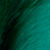

In [31]:
getCut(Image.open(picList[0][0],'r'),0.,coords[0][0],coords[0][1],50 )

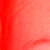

In [32]:
getCut(Image.open(picList[0][0],'r'),1.,coords[1][0],coords[1][1],50 )

Weights are rescaled to be between 0 and 1 for plotting purposes only:

In [33]:
def minMaxScale(d):
    
    # turn into pandas df
    df = pd.DataFrame(d,index=["num"]).T
    # we only do this for one column of data
    assert df.shape[1] == 1, "function not specified for multiple columns"
    
    # we apply min/max scaling in the standard way
    outDf = ( df-df.min() ) / ( df.max()-df.min() +.000000000001 ) # if min=max, we dont want to divide by zero
    
    # return the rescaled data (0-1) as a dictionary
    outDict = outDf.to_dict()
    # get rid of the redundant hierarchy of the dict (i.e. return the values of the first and only key)
    return outDict[ outDict.keys()[-1] ]

Example for the happy female face:

In [34]:
thisDict = bigWeightDf.ix['p001'].ix['f'].ix['hap'].to_dict()
print 'min:', float( pd.DataFrame(thisDict,index=['val']).T.min() )
print 'max:', float( pd.DataFrame(thisDict,index=['val']).T.max() )

min: -100.0
max: 151.851851852


In [35]:
minMaxDict = minMaxScale(thisDict)
print 'min:', float( pd.DataFrame(minMaxDict,index=['val']).T.min() )
print 'max:', float( pd.DataFrame(minMaxDict,index=['val']).T.max() )

min: 0.0
max: 1.0


Apply to one whole image:

In [36]:
def applyTransparency(im,pDict,dims,squareSize):
    
    #rescale the dict using min/max scaling
    pDict = minMaxScale(pDict)
    
    # dimension of the image
    width=dims[1]*squareSize
    height=dims[0]*squareSize
    # make all x,y coordinates for the image
    thisCoord = makeCoordinates(dims[1],dims[0],squareSize)
    # take the original image and convert it, so it has an alpha channel
    im = im.convert("RGBA")
    im = im.resize((width,height), PIL.Image.ANTIALIAS)
    imDim = im.getdata.im_self.size
    pixdata = im.load()
    
    # create an empty output image to which we will write
    imOut = Image.new("RGBA",
                      imDim,
                      (0,0,0))

    # for each position of a tile and its probability of being shown
    for key,pValue in pDict.iteritems():
        # get the position of the current square

        h,v = thisCoord[int(key)]
        # cut that square and apply the proability value
        cut = getCut( im, pValue, h, v, squareSize )
        # add the edited cutout to the output image
        imOut.paste(cut, (h,v))
        
    return imOut

Example:

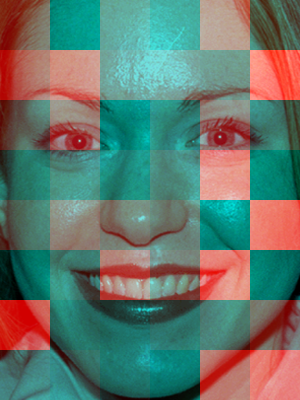

In [37]:
applyTransparency(Image.open(picList[0][0],'r'),
                  bigWeightDf.ix['p001'].ix['f'].ix['hap'].to_dict(),
                  (8,6),
                  50)

## The big plot

In [38]:
sns.set_style("white")

In [39]:
def plotAll(bigWeightDf,picList=picList,identDict=identDict,emoDict=emoDict):
    
    fig = plt.figure( figsize=(16,8) )

    i = 1 # counter for subplots
    for ident in range(2):
        for emo in range(7):
            pDict = bigWeightDf.ix[identDict[ident] ].ix[emoDict[emo] ].to_dict()
            im=Image.open(picList[ident][emo],'r')
            dims=(8,6);squareSize=50
            thisIm = applyTransparency(im,pDict,dims,squareSize)
            ax = plt.subplot(2,7,i)
            ax.imshow(thisIm)
            ax.set_yticks([]); ax.set_xticks([])
            i+=1
    plt.tight_layout()
    plt.savefig('../figures/mainWeightPlot.png',dpi=100)
    plt.show()

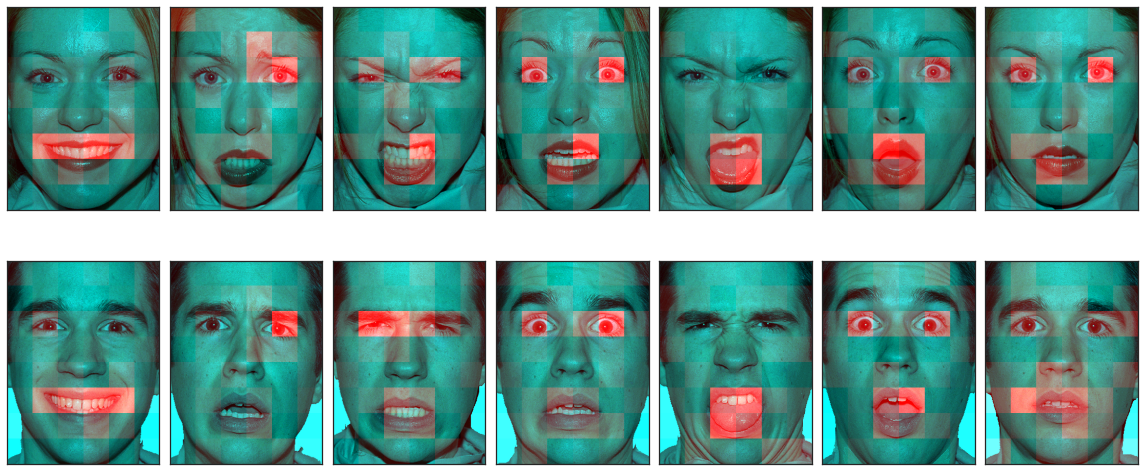

In [40]:
plotAll(bigAvgWeightDf)

# Generating image series for interactive plotting or making movies

In [41]:
from movieTools import *

sns.set_style('dark')

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



### Version 1: Weights of each participant

In [42]:
def plotAllInteractive(bigWeightDf,myTitle,counter,fileName,picList=picList,identDict=identDict,emoDict=emoDict):
    
    fig = plt.figure( figsize=(12,6) )

    i = 1 # counter for subplots
    for ident in range(2):
        for emo in range(7):

            pDict = bigWeightDf.ix[identDict[ident] ].ix[emoDict[emo] ].to_dict() # fillna 0
            im=Image.open(picList[ident][emo],'r')
            dims=(8,6);squareSize=50
            thisIm = applyTransparency(im,pDict,dims,squareSize)
                
            ax = plt.subplot(2,7,i)
            ax.imshow(thisIm)
            ax.set_yticks([]); ax.set_xticks([])
            i+=1
    plt.tight_layout()
    plt.suptitle(myTitle,fontsize=30)
    # we save as a series of images, so we can re-use them in other notebooks
    plt.savefig('../moviePics/'+fileName + ('00'+str(counter+1))[-3:] + '.png', dpi=100 )
    plt.close('all')
    return fig

In [43]:
def interactiveParticipantWeights(bigWeightDf):
    for i,p in enumerate(bigWeightDf.index.levels[0]):
        fig = plotAllInteractive(bigWeightDf.ix[p].fillna(0),'participant '+p,i,'weightInteractive')

In [44]:
interactiveParticipantWeights(bigWeightDf)

In [45]:
weightPics = getFile('../moviePics/','weightInteractive*.png')
weightPics[-5:]

['../moviePics/weightInteractive090.png',
 '../moviePics/weightInteractive091.png',
 '../moviePics/weightInteractive092.png',
 '../moviePics/weightInteractive093.png',
 '../moviePics/weightInteractive094.png']

In [46]:
#saveVideo(weightPics,'../movies/weightIndiMovie.mp4',myFps=5);

## Version 2: Accumulating more and more participants (sample grows)

In [47]:
def interactiveCum(bigWeightDf):
    
    for j in range(1,len(bigWeightDf.index.levels[0])+1):
            
        thisDf = bigWeightDf.ix[bigWeightDf.index.levels[0][:j]]
        meanDf = thisDf.groupby(level=[1,2]).mean()
        
        if pd.isnull(meanDf).any().any() == True: # check for nans
            meanDf = meanDf.fillna(0)
            
        myTitle = 'sample size: '+str(j)
        fig = plotAllInteractive(meanDf,myTitle,j-1,'weightsCumInteractive',
                                 picList=picList,identDict=identDict,emoDict=emoDict)    

In [48]:
interactiveCum(bigWeightDf)

In [49]:
weightPics = getFile('../moviePics/','weightsCumInteractive*.png')
weightPics[-5:]

['../moviePics/weightsCumInteractive090.png',
 '../moviePics/weightsCumInteractive091.png',
 '../moviePics/weightsCumInteractive092.png',
 '../moviePics/weightsCumInteractive093.png',
 '../moviePics/weightsCumInteractive094.png']

In [50]:
#saveVideo(weightPics,'../movies/weightCumMovie.mp4',myFps=5);

## Version 3: Accumulating with sample split in two (odd/even)

In [51]:
def plotAllInteractiveCV(df1,df2,myTitle,counter,fileName,picList=picList,identDict=identDict,emoDict=emoDict):
    
    fig = plt.figure( figsize=(12,12) )

    i = 1 # counter for subplots
    
    def oneSubplot(df,i,identDict=identDict,emoDict=emoDict):
        for ident in range(2):
            for emo in range(7):
                pDict = df.ix[identDict[ident] ].ix[emoDict[emo] ].to_dict()
                im=Image.open(picList[ident][emo],'r')
                dims=(8,6);squareSize=50
                thisIm = applyTransparency(im,pDict,dims,squareSize)
                ax = plt.subplot(4,7,i)
                ax.imshow(thisIm)
                ax.set_yticks([]); ax.set_xticks([])
                i+=1
        return i
    
    i = oneSubplot(df1,i)
    i = oneSubplot(df2,i)
    plt.suptitle(myTitle,fontsize=30)
    plt.tight_layout()
    # we save as a series of images, so we can re-use them in other notebooks
    plt.savefig('../moviePics/'+fileName + ('00'+str(counter+1))[-3:] + '.png', dpi=100 )
    plt.close('all')
    return fig

In [52]:
def interactiveCvCum(bigWeightDf):
    
    oneHalf = len(bigWeightDf.index.levels[0])/2
    for j in range(1, oneHalf+1):
        
        ####
        thisDf1 = bigWeightDf.ix[bigWeightDf.index.levels[0][0::2][:j]]
        meanDf1 = thisDf1.groupby(level=[1,2]).mean()
        
        if pd.isnull(meanDf1).any().any() == True: # check for nans
            meanDf1 = meanDf1.fillna(0)
        
        ####
        thisDf2 = bigWeightDf.ix[bigWeightDf.index.levels[0][1::2][:j]]
        meanDf2 = thisDf2.groupby(level=[1,2]).mean()
        
        if pd.isnull(meanDf2).any().any() == True: # check for nans
            meanDf2 = meanDf2.fillna(0)
                        
        myTitle = 'sample size: '+str(j)
        fig = plotAllInteractiveCV(meanDf1,meanDf2,myTitle,j-1,'weightsCvCumInteractive',
                                 picList=picList,identDict=identDict,emoDict=emoDict)    

In [53]:
interactiveCvCum(bigWeightDf)

In [54]:
weightPics = getFile('../moviePics/','weightsCvCumInteractive*.png')
weightPics[-5:]

['../moviePics/weightsCvCumInteractive043.png',
 '../moviePics/weightsCvCumInteractive044.png',
 '../moviePics/weightsCvCumInteractive045.png',
 '../moviePics/weightsCvCumInteractive046.png',
 '../moviePics/weightsCvCumInteractive047.png']

In [55]:
#saveVideo(weightPics,'../movies/weightCvCumMovie.mp4',myFps=5);